# Generative Latent Space Optimization

[Generative Latent Space Optimization](https://openreview.net/pdf?id=ryj38zWRb) (GLO) is perhaps one of the simplest DL-based Generative model there is. The central idea is to leverage the inductive-bias of conv-nets to create a generative model. GLO maps a *learnable* noise vector to each image of training dataset and alternatively optimizes these noise vectors and a conv-net. More concretely, consider a large dataset of $N$ images $\{x_{1}, x_{2}, \cdots, x_{N}\}$ where each $x_{i}$ is an image with dimensions $Channels \times W \times H$. Now, we pair with each $x_{i}$ a random vector $z_{i} \subseteq \mathbb{R}^{d}$ (a random vector of length $d$) which gives us a paired dataset $\{(z_{1}, x_{1}),(z_{2}, x_{2}), \cdots,  (z_{N}, x_{N})\}$ of size $N$. Next, we train the GLO model by carrying out the following minimizations on a minibatch of the paired dataset of size $M$:

$$
\underset{z_{i}}{\text{min }} \mathcal{L}(x_{i}, G_{\theta}(z_{i})) \quad \forall i = 1,\cdots,M \quad\quad (1)
$$
$$
\underset{\theta}{\text{min }} \sum_{i = 1}^{M}\mathcal{L}(x_{i}, G_{\theta}(z_{i})) \quad\quad (2)
$$

Here $G_{\theta}$ is a conv-net with parameters $\theta$ and $\mathcal{L}$ is the loss function. In the [paper](https://openreview.net/pdf?id=ryj38zWRb) and in this notebook the $z_{i}$ vectors are restricted to having the $L2$ norm less than or equal to one.

In this notebook we would be training a GLO model on the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. Each sample in this dataset is a grayscale image of some clothing item with size $28 \times 28$. All the code would be in [PyTorch](http://pytorch.org/).

## Broiler Plate Code


### Install PyTorch and Torchvision

If you are running this notebook in Google Colab you should download and PyTorch and Torchvision by running the cell below. Else, if you're running this locally you should have PyTorch 0.3.0 installed.

In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

    100% |████████████████████████████████| 592.3MB 57.9MB/s 
    100% |████████████████████████████████| 51kB 2.8MB/s 
    100% |████████████████████████████████| 5.9MB 235kB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


### Import libraries

In [0]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import numpy as np
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.optim as optim
import torchvision.utils as vutils
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

### Define TargetData and plotting tools

Here we define a Class that would pair up each image in FahsionMNIST with a learnable noise vector and a few plotting tools. The `TargetData` Class would allow us to samples minibatches from the paired-up dataset it creates.

In [0]:
class TargetData():

    def __init__(self):
        self.end = 0
        self.start = 0

    def fit(self, data_loader, latent_size=512):

        self.data_lst = []
        self.num_samples = 0
        for data, _ in data_loader:
            z = torch.randn(1, latent_size)
            self.data_lst.append([data, z/torch.norm(z)])
            self.img_size = 28
            self.num_samples += 1
        print('Number of samples: ', len(self.data_lst))

    def get_batch(self, batch_size=10):
        self.start = self.end
        start = self.start
        end = min(start + batch_size, self.num_samples)
        eff_batch = end - start
        if end >= self.num_samples:
            end = 0
        self.end = end
        data_out = None
        target_out = None
        for i in range(eff_batch):
            if data_out is None:
                data_out = self.data_lst[start + i][0]
            else:
                data_out = torch.cat([data_out, self.data_lst[start + i][0]])
            if target_out is None:
                target_out = self.data_lst[start + i][1]
            else:
                target_out = torch.cat([target_out, self.data_lst[start + i][1]])
        return data_out, target_out


    def get_batch_from(self, start, batch_size=10):
        start = start
        end = min(start + batch_size, self.num_samples)
        eff_batch = end - start
        if end >= self.num_samples:
            end = 0
        self.end = end
        data_out = None
        target_out = None
        for i in range(eff_batch):
            if data_out is None:
                data_out = self.data_lst[start + i][0]
            else:
                data_out = torch.cat([data_out, self.data_lst[start + i][0]])
            if target_out is None:
                target_out = self.data_lst[start + i][1]
            else:
                target_out = torch.cat([target_out, self.data_lst[start + i][1]])
        return data_out, target_out

    def update_state(self, data_in, latent_vec):
        num_samples = data_in.shape[0]
        for i in range(num_samples):
            self.data_lst[self.start + i][1] = latent_vec[i:i+1,:]
        if len(self.data_lst) != self.num_samples:
            print("Something's wrong!")

    def get_latent(self):
        latent_z = None
        for i in range(self.num_samples):
            if latent_z is None:
                latent_z = self.data_lst[i][1].numpy()
            else:
                latent_z = np.concatenate([latent_z, self.data_lst[i][1].numpy()])
        return latent_z

    def get_vec(self, idx):
        return self.data_lst[idx][1]
      
    
def plot_images(images, title):
  num_images = images.shape[0]
  imgs_lst = []
  for i in range(num_images):
    imgs_lst.append(images[i])
  show(vutils.make_grid(imgs_lst, padding=1), title)
  
def show(img, title):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.title(title)
    plt.grid('off')
    plt.axis('off')
    plt.show()

## Defining the Model

Here we define $G_{\theta}$.

In [0]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128, z_l=512):
        super(Generator, self).__init__()
        #Input size: (1, z_l, 1, 1)
        self.deconv1 = nn.ConvTranspose2d(z_l, d*8, 4, 1, 0, bias=False) #out size: 4
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 5, 1, 0, bias=False) #out size: 8
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 5, 1, 0, bias=False) #out size: 12
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 5, 1, 0, bias=False) #out size: 16
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 64, 5, 1, 0, bias=False) #out size: 20
        self.deconv5_bn = nn.BatchNorm2d(64)
        self.deconv6 = nn.ConvTranspose2d(64, 32, 5, 1, 0, bias=False) #out size: 24
        self.deconv6_bn = nn.BatchNorm2d(32)
        self.deconv7 = nn.ConvTranspose2d(32, 1, 5, 1, 0, bias=False) #out size: 28
        

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.relu(self.deconv5_bn(self.deconv5(x)))
        x = F.relu(self.deconv6_bn(self.deconv6(x)))
        x = F.sigmoid(self.deconv7(x))

        return x

### Initializing Variables

In [0]:
z_length = 512
CUDA = 0

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()])),
    batch_size=1, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=1, shuffle=True)


target_data = TargetData()
target_data.fit(train_loader, latent_size=z_length)


G = Generator(z_l=z_length)

if CUDA is not None:
    G.cuda(device=CUDA)
    
G_optimizer = optim.SGD(G.parameters(), lr=1)

Processing...
Done!
Number of samples:  60000


### Training Functions

Here is where we define training functions that carry out the minimizations. The function `trainZ` carries out the minimization shown in Eq. (1) and `trainG` carries out the minimization shown in Eq. (2). We use the mean-squared error as the loss function.

In [0]:
def trainG(epoch, data_in, z_in, num_epochs=100):
    G.train()
    for p in G.parameters():
        p.requires_grad=True
    z_in = z_in.view(-1, z_length, 1, 1)
    if CUDA is not None:
        data_in = data_in.cuda(device=CUDA)
        z_in = z_in.cuda(device=CUDA)
    data_in = Variable(data_in)
    z_in = Variable(z_in)
    for _ in range(num_epochs):
        G_optimizer.zero_grad()
        g_out = G(z_in)
        loss = F.mse_loss(g_out, data_in)
        loss.backward()
        G_optimizer.step()
    if epoch%100 == 0:
        G.eval()
        g_out = G(z_in)
        title = "Generated Images at Epoch %d"%(epoch)
        plot_images(g_out.data.cpu()[:5], title)
        
        
def trainZ(epoch, data_in, z_in, num_epochs=100):
    G.eval()
    for p in G.parameters():
        p.requires_grad=False
    z_in = z_in.view(-1, z_length, 1, 1)
    if CUDA is not None:
        data_in = data_in.cuda(device=CUDA)
        z_in = z_in.cuda(device=CUDA)
    data_in = Variable(data_in)
    z_in = Variable(z_in, requires_grad=True)
    optim_z = optim.SGD([z_in], lr=10)
    for ep in range(num_epochs):
        optim_z.zero_grad()
        g_out = G(z_in)
        loss = F.mse_loss(g_out, data_in)
        loss.backward()
        optim_z.step()
        ampt = torch.max(torch.norm(z_in.data, p=2, dim=1, keepdim=True).expand_as(z_in.data), 
                         torch.ones(z_in.size()).cuda(device=CUDA))
        z_in.data.div_(ampt)
    return z_in.data.cpu().view(-1, z_length)
  
  
def sampleG(z_in):
    G.eval()
    for p in G.parameters():
        p.requires_grad=False
    z_in = z_in.view(-1, z_length, 1, 1)
    num_samples = z_in.shape[0]
    if CUDA is not None:
        z_in = z_in.cuda(device=CUDA)
    z_in = Variable(z_in)
    g_out = G(z_in)
    title = "Generated Image Samples"
    plot_images(g_out.data.cpu(), title)

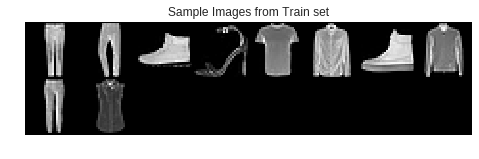

In [0]:
sample_imgs, _ = target_data.get_batch_from(100, batch_size=10)
plot_images(sample_imgs, 'Sample Images from Train set')

## Training the Model

Here is where we train the model as follows

$$
\underset{z_{i}}{\text{min }} \mathcal{L}(x_{i}, G_{\theta}(z_{i})) \quad \forall i = 1,\cdots,M \quad\quad
$$
$$
\underset{\theta}{\text{min }} \sum_{i = 1}^{M}\mathcal{L}(x_{i}, G_{\theta}(z_{i})) \quad\quad
$$


Where, the $z_{i}$'s are the latent vector, $x_{i}$'s are the images, $G_{\theta}$ is the conv-net and $\mathcal{L}$ is loss function (which is MSE in this case).

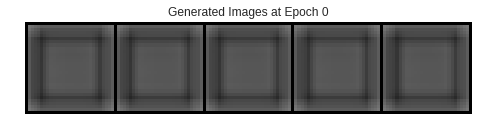

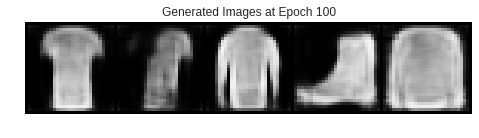

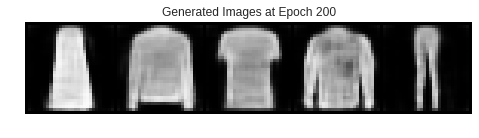

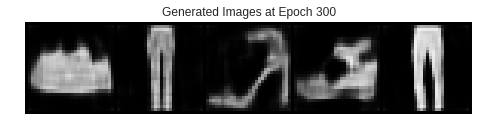

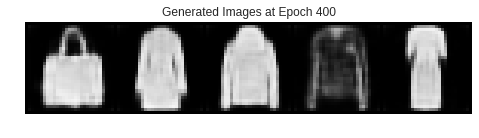

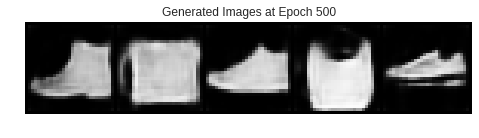

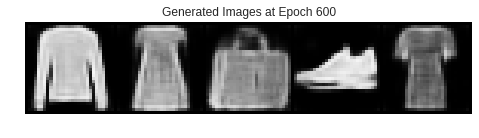

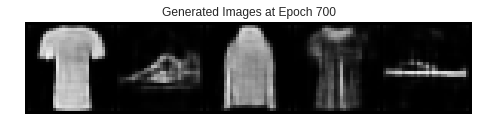

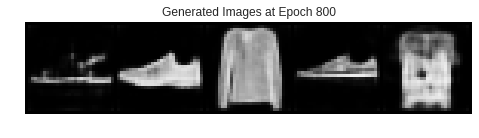

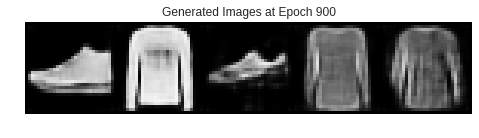

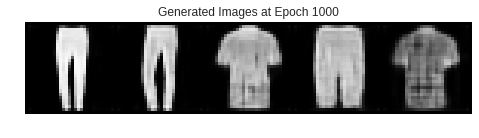

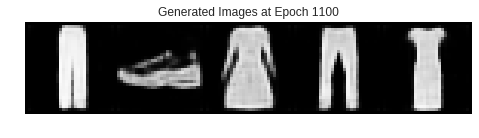

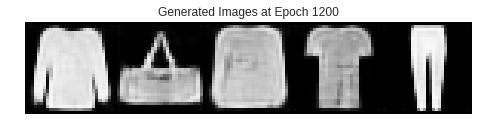

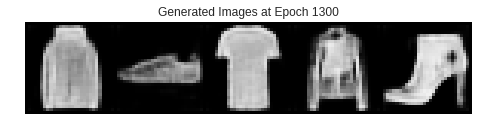

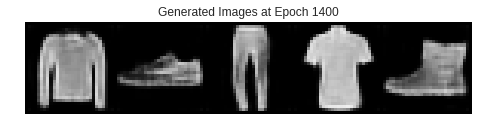

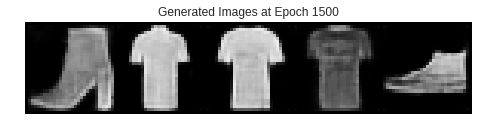

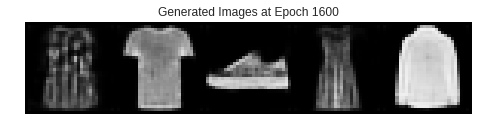

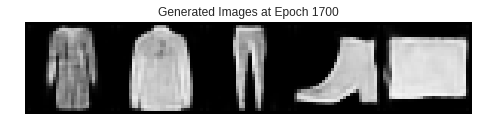

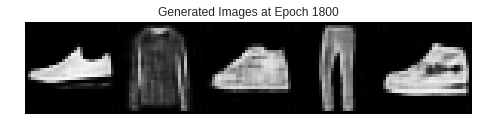

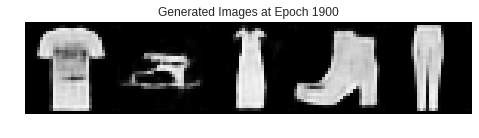

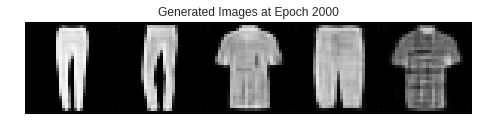

In [0]:
NUM_EPOCHS = 2000

for epoch in range(0, NUM_EPOCHS + 1):
    data_in, z_in = target_data.get_batch(batch_size=60)
    z_in = trainZ(epoch, data_in, z_in, num_epochs=10)
    trainG(epoch, data_in, z_in, num_epochs=10)
    target_data.update_state(data_in, z_in)
    print ('Iteration %05d' % (epoch), '\r', end='')

## Sampling from the Model

We sample from the model by fitting a full-covariance gaussian to all of the $z_{i}$'s that are learnt by the GLO model. As you can see from the results below, the sampled images are not too bad, though they are sometimes a bit blurry or incomplete. There are better ways to sample from the latent space but this perhaps is one of the simplest and is the one the paper uses.

In [0]:
class SampleLatent():

    def __init__(self, latent_vecs):
        self.latent_vecs = latent_vecs
        self.gm = GaussianMixture()
        self.gm.fit(self.latent_vecs)

    def get_batch(self, batch_size):
        return self.gm.sample(batch_size)

    def get_org_batch(self, batch_size):
        return self.latent_vecs[:batch_size]

In [0]:
z_vecs = target_data.get_latent()      
latent_sampler = SampleLatent(z_vecs)

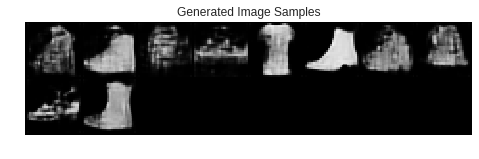

In [0]:
z_samp_np = latent_sampler.get_batch(10)
z_samp = torch.from_numpy(z_samp_np[0]).float()
sampleG(z_samp)